## Feature Engineering Deep Dive チュートリアル

- [1. データの読み込みと確認](#readData)
    - データのロードと内容確認
    - 型変換
- [2. ベースラインモデルの作成](#baseline)
    - AutoML
    - モデルパフォーマンスと変数重要度の確認
- [3. Feature Engineeringとそれを利用したモデルの作成](#FE)
    - Feature Engineeringの実施
    - XXX

In [1]:
import h2o
import matplotlib as plt
%matplotlib inline
from h2o.automl import H2OAutoML

In [2]:
#> H2Oクラスターの開始
h2o.init(url='http://localhost:54321')

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /home/ec2-user/anaconda3/envs/h2o_3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9dhp5bk8
  JVM stdout: /tmp/tmp9dhp5bk8/h2o_ec2_user_started_from_python.out
  JVM stderr: /tmp/tmp9dhp5bk8/h2o_ec2_user_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Asia/Tokyo
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.2
H2O_cluster_version_age:    1 month and 4 days
H2O_cluster_name:           H2O_from_python_ec2_user_qkzxka
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.399 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.6.12 final
--------------------------  ------------------------------------------------------------------

<a id='readData'></a>
### 1. データの読み込みと確認

In [3]:
#> データのロード
loans = h2o.import_file("https://sample-data-open.s3-ap-northeast-1.amazonaws.com/h2o_sample_loan/loan.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [4]:
loans.head(5)

loan_amnt term int_rate emp_length home_ownership annual_inc purpose addr_state dti delinq_2yrs revol_util total_acc bad_loan longest_credit_length verification_status 
 
 
 5000 36 months 10.65 10 RENT 24000 credit_card AZ 27.65 0 83.7 9 0 26 verified 
 2500 60 months 15.27 0 RENT 30000 car GA 1 0 9.4 4 1 12 verified 
 2400 36 months 15.96 10 RENT 12252 small_business IL 8.72 0 98.5 10 0 10 not verified 
 10000 36 months 13.49 10 RENT 49200 other CA 20 0 21 37 0 15 verified 
 5000 36 months 7.9 3 RENT 36000 wedding AZ 11.2 0 28.3 12 0 7 verified

In [5]:
loans.describe()

Rows:163987
Cols:15




loan_amnt term int_rate emp_length home_ownership annual_inc purpose addr_state dti delinq_2yrs revol_util total_acc bad_loan longest_credit_length verification_status 
 
 
 type int enum real int enum real enum enum real int real int int int enum 
 mins 500.0 5.42 0.0 1896.0 0.0 0.0 0.0 1.0 0.0 0.0 
 mean 13074.169141456336 13.715904065566168 5.684352932995333 71915.67051974915 15.881530121290089 0.2273570060625282 54.07917280242262 24.57973383427463 0.1830388994249544 14.854273655448353 
 maxs 35000.0 26.06 10.0 7141778.0 39.99 29.0 150.70000000000002 118.0 1.0 65.0 
 sigma 7993.556188734652 4.3919398705457935 3.610663731100237 59070.91565491827 7.587668224192549 0.694167922928418 25.285366766770515 11.685190365910659 0.3866995896078875 6.947732922546697 
 zeros 0 0 14248 0 270 139459 1562 0 133971 11 
 missing 0 0 0 5804 0 4 0 0 0 29 193 29 0 29 0 
 0 5000.0 36 months 10.65 10.0 RENT 24000.0 credit_card AZ 27.65 0.0 83.7 9.0 0.0 26.0 verified 
 1 2500.0 60 months 15.27 0.0 RENT 30000.0 car GA 1.0 0.0 9.4 4.0 1.0 12.0 verified 
 2 2400.0 36 months 15.96 10.0 RENT 12252.0 small_business IL 8.72 0.0 98.5 10.0 0.0 10.0 not verified 
 3 10000.0 36 months 13.49 10.0 RENT 49200.0 other CA 20.0 0.0 21.0 37.0 0.0 15.0 verified 
 4 5000.0 36 months 7.9 3.0 RENT 36000.0 wedding AZ 11.2 0.0 28.3 12.0 0.0 7.0 verified 
 5 3000.0 36 months 18.64 9.0 RENT 48000.0 car CA 5.3500000000000005 0.0 87.5 4.0 0.0 4.0 verified 
 6 5600.0 60 months 21.28 4.0 OWN 40000.0 small_business CA 5.55 0.0 32.6 13.0 1.0 7.0 verified 
 7 5375.0 60 months 12.69 0.0 RENT 15000.0 other TX 18.08 0.0 36.5 3.0 1.0 7.0 verified 
 8 6500.0 60 months 14.65 5.0 OWN 72000.0 debt_consolidation AZ 16.12 0.0 20.6 23.0 0.0 13.0 not verified 
 9 12000.0 36 months 12.69 10.0 OWN 75000.0 debt_consolidation CA 10.78 0.0 67.10000000000001 34.0 0.0 22.0 verified

#### データに関して

[LendingClub](https://www.lendingclub.com/info/statistics.action)データに対しデータクレンジングと簡素化を実施したもの

|Id  | Column Name | Description | 説明 |
|:---|:----------------------|:-------------------|:-------------------|
|1   | loan_amnt             | Requested loan amount (US dollars)       | 申し込まれたローンの額(USD) |
|2   | term                  | Loan term length (months)       | 申し込まれたローン期間(月) |
|3   | int_rate              | Recommended interest rate       | 貸出金利 |
|4   | emp_length            | Employment length (years)       | 継続雇用期間(年) |
|5   | home_ownership        | Housing status       | 住居形態 |
|6   | annual_inc            | Annual income (US dollars)       | 年収(USD) |
|7   | purpose               | Purpose for the loan       | ローン借り入れ理由 |
|8   | addr_state            | State of residence       | 居住州 |
|9   | dti                   | Debt to income ratio       | 負債比率(%)（既存のローンの返済額を借り手の月収で割った率） |
|10  | delinq_2yrs           | Number of delinquencies in the past 2 years       | 過去2年における滞納回数 |
|11  | revol_util            | Percent of revolving credit line utilized       | リボルビングクレジット利用率(%) |
|12  | total_acc             | Number of active accounts       | 与信枠数 |
|13  | bad_loan              | Bad loan indicator       | 不良貸し付け |
|14  | longest_credit_length | Age of oldest active account       | 最長の与信枠(年) |
|15  | verification_status   | Income verification status       | 所得確認状況 |

参考：[Lending Club Loan Analysis](Lending Club Loan Analysis) on Kaggle Notebook

`bad_loan`をターゲットとしてモデル作成

In [6]:
#> int型をカテゴリ型(enum)へ変更
loans['bad_loan'] = loans['bad_loan'].asfactor()

In [7]:
loans['bad_loan'].describe()

Rows:163987
Cols:1




bad_loan 
 
 
 type enum 
 mins 
 mean 
 maxs 
 sigma 
 zeros 
 missing 0 
 0 0 
 1 1 
 2 0 
 3 0 
 4 0 
 5 0 
 6 1 
 7 1 
 8 0 
 9 0

In [8]:
#> 水準数の確認（1:不良貸し付け）
loans['bad_loan'].table()

bad_loan Count 
 
 
 0 133971 
 1 30016

In [9]:
#> 学習/テストデータセットへの分割（学習 :  テスト = 80% : 20% ）
train, test = loans.split_frame([0.8], seed=12345)
print(">> train/testのデータ数")
print("train:%d test:%d" % (train.nrows, test.nrows))

>> train/testのデータ数
train:131248 test:32739


<a id='baseline'></a>
### 2. ベースラインモデルの作成

In [10]:
response = "bad_loan"   # ターゲット変数

predictors = train.col_names
predictors.remove(response)
predictors.remove("int_rate")
predictors   # 特徴量(13)

['loan_amnt',
 'term',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'purpose',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'revol_util',
 'total_acc',
 'longest_credit_length',
 'verification_status']

In [11]:
aml = H2OAutoML(max_models = 6,
                max_runtime_secs_per_model = 60,
                exclude_algos = ['DRF', 'DeepLearning', 'StackedEnsemble'],
                seed = 12345)

%time aml.train(x = predictors, y = response, training_frame = train)

AutoML progress: |█████████
08:52:34.365: GLM_1_AutoML_20201008_085019 [GLM def_1] failed: java.lang.ArrayIndexOutOfBoundsException: 82

███████████████████████████████████████████████| 100%
CPU times: user 5.52 s, sys: 141 ms, total: 5.67 s
Wall time: 3min 48s


- max_models（作成する最大モデル数）かmax_runtime_secs（最大実行時間数）の設定に達すると、探索が終了（[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#required-stopping-parameters)）
- [exclude_algos](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/exclude_algos.html)にしたアルゴリズムはAutoMLで試行されない

In [12]:
#> k分割交差検証法の分割数(k)
aml.nfolds

5

In [13]:
#> k分割交差検証法による結果。AUC順
aml.leaderboard

model_id auc logloss aucpr mean_per_class_error rmse mse 
 
 
 GBM_1_AutoML_20201008_085019 0.681176 0.443732 0.319553 0.36962 0.373555 0.139544 
 XGBoost_3_AutoML_20201008_085019 0.679816 0.444138 0.318098 0.370936 0.373766 0.139701 
 GBM_2_AutoML_20201008_085019 0.679021 0.444618 0.315893 0.371141 0.374013 0.139886 
 GBM_3_AutoML_20201008_085019 0.676137 0.445671 0.313651 0.372875 0.374456 0.140217 
 XGBoost_1_AutoML_20201008_085019 0.660832 0.45526 0.297487 0.384246 0.378586 0.143327 
 XGBoost_2_AutoML_20201008_085019 0.64458 0.469616 0.282045 0.396293 0.383979 0.14744

並び順に関しての[ドキュメント](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/sort_metric.html)

In [14]:
#> leaderboardの一番上のモデル
aml.leader

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_1_AutoML_20201008_085019


Model Summary: 


number_of_trees    number_of_internal_trees    model_size_in_bytes    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves
--  -----------------  --------------------------  ---------------------  -----------  -----------  ------------  ------------  ------------  -------------
    52                 52                          47957                  6            6            6             32            64            58.9231



ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.1330293974524767
RMSE: 0.3647319528811216
LogLoss: 0.4254314489578683
Mean Per-Class Error: 0.33645415118293
AUC: 0.7257812953735341
AUCPR: 0.40112712250300603
Gini: 0.45156259074706817

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21000410129532213: 


0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      80870  26438  0.2464   (26438.0/107308.0)
1      10368  13572  0.4331   (10368.0/23940.0)
Total  91238  40010  0.2804   (36806.0/131248.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.210004     0.424457  221
max f2                       0.123976     0.569923  313
max f0point5                 0.309659     0.414528  142
max accuracy                 0.416478     0.825392  82
max precision                0.856613     1         0
max recall                   0.0358396    1         398
max specificity              0.856613     1         0
max absolute_mcc             0.249072     0.271708  188
max min_per_class_accuracy   0.183263     0.661908  247
max mean_per_class_accuracy  0.185238     0.663546  245
max tns                      0.856613     107308    0
max fns                      0.856613     23938     0
max fps                      0.0314168    107308    399
max tps                      0.0358396    23940     398
max tnr                      0.856613     1         0
max fnr                      0.856613     0.999916  0
max fpr                      0.0314168    1         399
max tpr                      0.0358396    1         398


Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.26 %


group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010004                    0.509204           4.09612   4.09612            0.747144         0.572163   0.747144                    0.572163            0.0409774       0.0409774                  309.612   309.612            0.0378835
2        0.0200003                   0.457852           3.31784   3.70713            0.605183         0.480447   0.67619                     0.526322            0.0331662       0.0741437                  231.784   270.713            0.0662226
3        0.0300043                   0.427133           2.91864   3.44423            0.532369         0.441654   0.628238                    0.498093            0.029198        0.103342                   191.864   244.423            0.0896987
4        0.0400006                   0.403387           2.70358   3.25914            0.49314          0.414617   0.594476                    0.477232            0.0270259       0.130368                   170.358   225.914            0.110527
5        0.0500046                   0.383508           2.5345    3.11417            0.4623           0.393153   0.568033                    0.460411            0.0253551       0.155723                   153.45    211.417            0.129303
6        0.100002                    0.320561           2.1622    2.63822            0.394392         0.348773   0.481219                    0.404596            0.108104        0.263826                   116.22    163.822            0.200373
7        0.150006                    0.280387           1.76174   2.34605            0.321347         0.299464   0.427926                    0.36955             0.0880952       0.351921                   76.1744   134.605            0.246962
8        0.200003                    0.251424           1.5473    2.14637            0.282231         0.265316   0.391505                    0.343494            0.0773601       0.429282                   54.7296   114.637            0.28043
9        0.300005                    0.211053           1.31577   1.86951            0.24             0.229988   0.341003                    0.305658            0.131579        0.56086                    31.5769   86.9506            0.319052
10       0.399998                    0.181878           1.05687   1.66636            0.192777         0.195737   0.303949                    0.27818             0.105681        0.666541                   5.68731   66.636             0.326008
11       0.5                         0.158045           0.878015  1.50869            0.160152         0.169633   0.275189                    0.25647             0.0878028       0.754344                   -12.1985  50.8688            0.311087
12       0.600002                    0.137852           0.726388  1.3783             0.132495         0.147674   0.251406                    0.238337            0.0726399       0.826984                   -27.3612  37.8303            0.277622
13       0.699995                    0.119838           0.652504  1.27462            0.119019         0.128766   0.232495                    0.222685            0.0652464       0.892231                   -34.7496  27.4623            0.235122
14       0.799997                    0.101718           0.488714  1.17638            0.0891429        0.110776   0.214576                    0.208696            0.0488722       0.941103                   -51.1286  17.6383            0.172586
15       0.899998                    0.0809351          0.385124  1.08846            0.0702476        0.



ModelMetricsBinomial: gbm
** Reported on cross-validation data. **

MSE: 0.13954355878848432
RMSE: 0.37355529548981675
LogLoss: 0.44373204240160347
Mean Per-Class Error: 0.36793432447933117
AUC: 0.6811763163001875
AUCPR: 0.3195529756610926
Gini: 0.362352632600375

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19121624842192197: 


0      1      Error    Rate
-----  -----  -----  -------  ------------------
0      72998  34310  0.3197   (34310.0/107308.0)
1      10043  13897  0.4195   (10043.0/23940.0)
Total  83041  48207  0.3379   (44353.0/131248.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.191216     0.385241  235
max f2                       0.113116     0.551538  321
max f0point5                 0.275878     0.346527  160
max accuracy                 0.536628     0.817971  33
max precision                0.834213     1         0
max recall                   0.034767     1         397
max specificity              0.834213     1         0
max absolute_mcc             0.198377     0.209207  228
max min_per_class_accuracy   0.178389     0.629616  247
max mean_per_class_accuracy  0.170065     0.632066  255
max tns                      0.834213     107308    0
max fns                      0.834213     23938     0
max fps                      0.0164426    107308    399
max tps                      0.034767     23940     397
max tnr                      0.834213     1         0
max fnr                      0.834213     0.999916  0
max fpr                      0.0164426    1         399
max tpr                      0.034767     1         397


Gains/Lift Table: Avg response rate: 18.24 %, avg score: 18.22 %


group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.010004                    0.50474            2.7558    2.7558             0.502666         0.563913   0.502666                    0.563913            0.0275689       0.0275689                  175.58    175.58             0.0214836
2        0.0200003                   0.45492            2.56986   2.66287            0.46875          0.477531   0.485714                    0.520739            0.0256892       0.0532581                  156.986   166.287            0.0406775
3        0.0300043                   0.424099           2.30903   2.54489            0.421173         0.438426   0.464195                    0.493294            0.0230994       0.0763576                  130.903   154.489            0.0566945
4        0.0400006                   0.400737           2.20214   2.45924            0.401677         0.412039   0.448571                    0.472988            0.0220134       0.0983709                  120.214   145.924            0.0713925
5        0.0500046                   0.381668           2.12531   2.39243            0.387662         0.391174   0.436386                    0.45662             0.0212615       0.119632                   112.531   139.243            0.0851615
6        0.100002                    0.319052           1.90571   2.14909            0.347607         0.347      0.392                       0.401814            0.0952799       0.214912                   90.5713   114.909            0.140547
7        0.150006                    0.279424           1.62224   1.97346            0.295901         0.297968   0.359965                    0.367197            0.0811195       0.296032                   62.2241   97.3465            0.178603
8        0.200003                    0.251198           1.49466   1.85377            0.27263          0.264785   0.338133                    0.341596            0.0747285       0.37076                    49.4661   85.3773            0.208852
9        0.300005                    0.211133           1.29488   1.66748            0.23619          0.230058   0.304152                    0.304417            0.12949         0.500251                   29.4884   66.7477            0.24492
10       0.399998                    0.181879           1.13165   1.53353            0.206416         0.19597    0.27972                     0.277307            0.113158        0.613409                   13.1648   53.3527            0.261021
11       0.5                         0.157819           0.977011  1.42222            0.17821          0.1695     0.259417                    0.255745            0.0977026       0.711111                   -2.2989   42.2222            0.258209
12       0.600002                    0.137835           0.805752  1.31948            0.146971         0.147599   0.240676                    0.23772             0.0805764       0.791688                   -19.4248  31.9476            0.23445
13       0.699995                    0.119326           0.716418  1.23333            0.130677         0.128517   0.224963                    0.222121            0.0716374       0.863325                   -28.3582  23.3329            0.199768
14       0.799997                    0.101185           0.601077  1.1543             0.109638         0.110336   0.210547                    0.208147            0.0601086       0.923434                   -39.8923  15.4296            0.150975
15       0.899998                    0.0809752          0.467411  1.07797            0.0852571        0



Cross-Validation Metrics Summary: 


mean        sd            cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------  ----------  ------------  ------------  ------------  ------------  ------------  ------------
accuracy     0.64853543  0.01507191    0.6656        0.64849526    0.6501333     0.65408206    0.62436664
auc          0.6811718   0.002338276   0.67988724    0.67933655    0.68495834    0.67976797    0.6819087
aucpr        0.31993786  0.004454398   0.31562677    0.317051      0.32592648    0.32335785    0.31772715
err          0.35146454  0.01507191    0.3344        0.35150477    0.34986666    0.34591794    0.37563336
err_count    9225.8      395.5189      8778.0        9227.0        9184.0        9080.0        9860.0
---          ---         ---           ---           ---           ---           ---           ---
precision    0.28371045  0.004082744   0.2852016     0.28168464    0.28660315    0.28749123    0.2775716
r2           0.0642686   0.0020600415  0.062460016   0.06299081    0.06769801    0.06445181    0.06374234
recall       0.606909    0.028841445   0.57391673    0.60306144    0.61493534    0.591782      0.6508496
rmse         0.37355292  0.0014946816  0.37147263    0.373236      0.3730546     0.37518486    0.37481654
specificity  0.657759    0.024675617   0.68563735    0.65858203    0.6579978     0.6681771     0.6184008


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------
    2020-10-08 08:53:02  27.985 sec  0                  0.386176         0.475017            0.5             0.182403           1                0.817597
    2020-10-08 08:53:02  28.412 sec  5                  0.378506         0.456438            0.686677        0.341127           3.26272          0.318953
    2020-10-08 08:53:03  28.804 sec  10                 0.374227         0.446749            0.694804        0.354703           3.55749          0.318534
    2020-10-08 08:53:03  29.194 sec  15                 0.371776         0.441211            0.700571        0.362717           3.63682          0.31778
    2020-10-08 08:53:03  29.562 sec  20                 0.370129         0.437519            0.704075        0.369115           3.78714          0.305567
    2020-10-08 08:53:04  29.920 sec  25                 0.368869         0.434685            0.708773        0.375917           3.85812          0.308881
    2020-10-08 08:53:04  30.278 sec  30                 0.367974         0.432619            0.712293        0.380881           3.86647          0.313963
    2020-10-08 08:53:05  30.647 sec  35                 0.367114         0.43063             0.715874        0.385359           3.88317          0.305742
    2020-10-08 08:53:05  31.017 sec  40                 0.366299         0.428829            0.719387        0.390594           3.99174          0.291517
    2020-10-08 08:53:05  31.418 sec  45                 0.365549         0.427177            0.722818        0.395748           4.05019          0.282313
    2020-10-08 08:53:06  31.798 sec  50                 0.365            0.426002            0.724741        0.399229           4.06272          0.28024
    2020-10-08 08:53:06  31.984 sec  52                 0.364732         0.425431            0.725781        0.401127           4.09612          0.280431


Variable Importances: 


variable               relative_importance    scaled_importance    percentage
---------------------  ---------------------  -------------------  ------------
term                   1979.08                1                    0.20038
addr_state             1958.39                0.989545             0.198285
annual_inc             1266.58                0.639982             0.12824
revol_util             1105.3                 0.55849              0.11191
dti                    896.082                0.452777             0.0907275
purpose                860.982                0.435041             0.0871738
loan_amnt              645.693                0.326259             0.0653759
longest_credit_length  256.834                0.129774             0.0260042
total_acc              235.71                 0.119101             0.0238655
emp_length             232.264                0.117359             0.0235165
home_ownership         220.322                0.111325             0.0223074
delinq_2yrs            148.849                0.075211             0.0150708
verification_status    70.542                 0.0356438            0.00714232

In [15]:
#> テストデータに対する結果の取得
perf = aml.leader.model_performance(test_data=test)
perf


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.14128182734644792
RMSE: 0.37587474954623906
LogLoss: 0.4478148716073599
Mean Per-Class Error: 0.364585167902983
AUC: 0.6834644287536212
AUCPR: 0.3227999011453459
Gini: 0.36692885750724247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19705499862227122: 


0      1      Error    Rate
-----  -----  -----  -------  -----------------
0      18841  7822   0.2934   (7822.0/26663.0)
1      2662   3414   0.4381   (2662.0/6076.0)
Total  21503  11236  0.3202   (10484.0/32739.0)


Maximum Metrics: Maximum metrics at their respective thresholds


metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.197055     0.394409  222
max f2                       0.106007     0.55569   328
max f0point5                 0.253064     0.354823  172
max accuracy                 0.509683     0.81493   36
max precision                0.822082     1         0
max recall                   0.0380764    1         395
max specificity              0.822082     1         0
max absolute_mcc             0.211327     0.222425  208
max min_per_class_accuracy   0.177394     0.633575  243
max mean_per_class_accuracy  0.188128     0.635415  231
max tns                      0.822082     26663     0
max fns                      0.822082     6075      0
max fps                      0.0279239    26663     399
max tps                      0.0380764    6076      395
max tnr                      0.822082     1         0
max fnr                      0.822082     0.999835  0
max fpr                      0.0279239    1         399
max tpr                      0.0380764    1         395


Gains/Lift Table: Avg response rate: 18.56 %, avg score: 18.16 %


group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100186                   0.500588           2.74341   2.74341            0.509146         0.5561     0.509146                    0.5561              0.0274852       0.0274852                  174.341   174.341            0.0214469
2        0.0200067                   0.448509           2.10916   2.42677            0.391437         0.471218   0.450382                    0.513723            0.0210665       0.0485517                  110.916   142.677            0.0350498
3        0.0300254                   0.420432           2.11916   2.32413            0.393293         0.434082   0.431333                    0.487149            0.0212311       0.0697828                  111.916   132.413            0.0488174
4        0.0400134                   0.396846           2.43872   2.35273            0.452599         0.407985   0.436641                    0.467389            0.0243581       0.0941409                  143.872   135.273            0.0664621
5        0.0500015                   0.379323           1.97734   2.27774            0.366972         0.387674   0.422724                    0.451465            0.0197498       0.113891                   97.7339   127.774            0.0784483
6        0.100003                    0.320736           1.92555   2.10165            0.357361         0.346815   0.390043                    0.39914             0.0962804       0.210171                   92.555    110.165            0.135273
7        0.150005                    0.279033           1.75439   1.9859             0.325596         0.298636   0.36856                     0.365639            0.0877222       0.297893                   75.439    98.5895            0.18159
8        0.200006                    0.251191           1.57994   1.88441            0.293219         0.264659   0.349725                    0.340394            0.0789993       0.376893                   57.9939   88.4406            0.217196
9        0.300009                    0.2107             1.36105   1.70995            0.252596         0.229798   0.317349                    0.303528            0.136109        0.513002                   36.1051   70.9954            0.26153
10       0.400012                    0.180722           1.06646   1.54908            0.197923         0.195004   0.287492                    0.276397            0.106649        0.619651                   6.64585   54.908             0.26969
11       0.500015                    0.157255           0.923277  1.42392            0.17135          0.168796   0.264264                    0.254877            0.0923305       0.711982                   -7.67234  42.392             0.260269
12       0.599988                    0.136818           0.82149   1.32354            0.15246          0.146765   0.245635                    0.236863            0.0821264       0.794108                   -17.851   32.354             0.238357
13       0.699991                    0.118891           0.669828  1.23015            0.124313         0.127799   0.228302                    0.221282            0.0669849       0.861093                   -33.0172  23.0149            0.197814
14       0.799994                    0.101465           0.597414  1.15105            0.110874         0.110392   0.213623                    0.20742             0.0597433       0.920836                   -40.2586  15.1054            0.14838
15       0.899997                    0.080869           0.480565  1.07655            0.0891875        0.0

**各データセット、検証におけるAUCの比較**

In [16]:
print("AUC: train = {:.4f}, X-val = {:.4f}, test = {:.4f}".format(aml.leader.auc(train = True),
                                                                  aml.leader.auc(xval = True), 
                                                                  perf.auc()))

AUC: train = 0.7258, X-val = 0.6812, test = 0.6835


**変数重要度の確認**

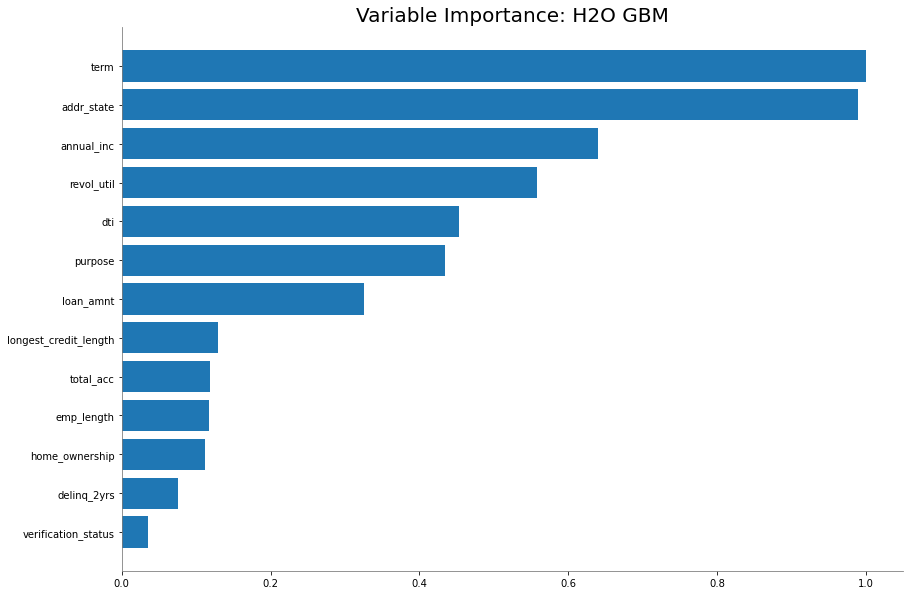

In [17]:
aml.leader.varimp_plot(13)

上位に入るaddr_stateは50水準、purposeは14水準のカテゴリカル変数

In [42]:
print( loans['addr_state'].table().dim[0] )
print( loans['purpose'].table().dim[0] )

50
14


<a id='FE'></a>
### 3. Feature Engineeringとそれを利用したモデルの作成

練習として、以下5つのFeature Engineeringをそれぞれの変数に実施する
1. **代数変換(Algebraic Transformation)**
    - 年収(USD)(annual_inc)と与信枠数(total_acc)の比
<br><br>
2. **Target Encoding**
    - 居住数(addr_state)
    - ローン借り入れ理由(purpose)
<br><br>
3. **Combining Categories**
    - 住所形態(home_ownership)
<br><br>
4. **Indicator Functions**
    - 申し込まれたローン期間(月)(term)
    - 所得確認状況(verification_status)
    - 継続雇用期間(年)(emp_length) - 欠損を示すIndicator
<br><br>
5. **Separating Typical from Extreme**
    - 申し込まれたローンの額(USD)(loan_amnt)
    - リボルビングクレジット利用率(%)(revol_util)
    - 過去2年における滞納回数(delinq_2yrs)
    - 年収(USD)(annual_inc)
    - 負債比率(%)(dti)
    - 与信枠数(total_acc)
    - Longest Credit Length(?)

#### 1. 代数変換(Algebraic Transformation)

与信枠数に対する年収を算出`annual_inc/total_acc`  
分布の歪みを整えるため、対数変換も実施

Probs annual_incQuantiles 
 
 
 0.01 794.19 
 0.1 1400 
 0.25 1928.57 
 0.333 2189.45 
 0.5 2772.73 
 0.667 3529.41 
 0.75 4090.91 
 0.9 6000 
 0.99 13562.2

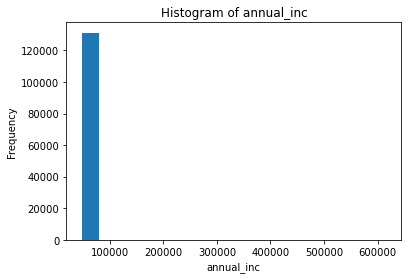

In [37]:
#> 対数変換しない場合
print( (train['annual_inc']/train['total_acc']).quantile() )
(train['annual_inc']/train['total_acc']).hist()

Probs log(annual_inc)Quantiles 
 
 
 0.01 6.67732 
 0.1 7.24423 
 0.25 7.56453 
 0.333 7.69141 
 0.5 7.92759 
 0.667 8.16889 
 0.75 8.31652 
 0.9 8.69951 
 0.99 9.51504

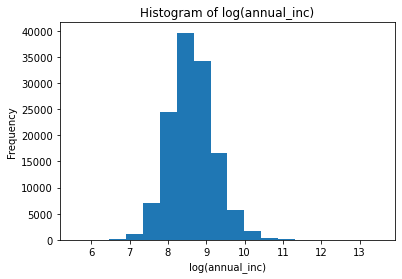

In [36]:
#> 対数変換した場合
print( (train['annual_inc'].log()-train['total_acc'].log()).quantile() )
(train['annual_inc'].log()-train['total_acc'].log()).hist()

In [40]:
transformed = predictors.copy()    # Feature Engineeringを加えた変数のリストtransformedとする

train['log_inc_per_acct'] = train['annual_inc'].log()-train['total_acc'].log()

transformed.append('log_inc_per_acct')
len(transformed)

14

#### 2. Target Encoding

多水準カテゴリカル変数(High-cardinality Categorical Variable)に対し、Cross Varidationを用いた平均値によるTarget Encodingを実施（One-hot Encodingを多水準カテゴリカル変数に実施した場合、オーバーフィッティングが発生する可能性が高いため）  

[参考リソース](https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/categorical-predictors/target_encoding.md)

In [43]:
cv_nfolds = 5
cv_seed = 12345
train["cv_fold"] = train.kfold_column(n_folds=cv_nfolds, seed=cv_seed)

train["cv_fold"].table()

cv_fold Count 
 
 
 0 26201 
 1 26268 
 2 26424 
 3 26020 
 4 26335

In [57]:
import numpy as np
import pandas as pd

def logit(p):
    return np.log(p) - np.log(1 - p)

def mean_target(data, x, y="bad_loan"):
    grouped_data = data[[x, y]].group_by([x])
    stats = grouped_data.count(na="ignore").mean(na="ignore")
    return stats.get_frame().as_data_frame()

def mean_target_encoding(data, x, y="bad_loan", fold_column="cv_fold", prior_mean=0.183, prior_count=1):
    """
    Creates target encoding for binary target
    data (H2OFrame) : data set
    x (string) : categorical predictor column name
    y (string) : binary target column name
    fold_column (string) : cross-validation fold column name
    prior_mean (float) : proportion of 1s in the target column
    prior_count (positive number) : weight to give to prior_mean
    """ 
    grouped_data = data[[x, fold_column, y]].group_by([x, fold_column])
    grouped_data.sum(na = "ignore").count(na = "ignore")
    df = grouped_data.get_frame().as_data_frame()
    df_list = []
    nfold = int(data[fold_column].max()) + 1
    for j in range(0, nfold):
        te_x = "te_{}".format(x)
        sum_y = "sum_{}".format(y)
        oof = df.loc[df[fold_column] != j, [x, sum_y, "nrow"]]
        stats = oof.groupby([x]).sum()
        stats[x] = stats.index
        stats[fold_column] = j
        p = (stats[sum_y] + (prior_count * prior_mean)) / (stats["nrow"] + prior_count)
        stats[te_x] = logit(p)
        df_list.append(stats[[x, fold_column, te_x]])
    #return h2o.H2OFrame(pd.concat(df_list))
    return pd.concat(df_list)

In [49]:
tbl = train["purpose"].table().as_data_frame()
tbl

purpose  Count
0                  car   2280
1          credit_card  24713
2   debt_consolidation  74560
3          educational    312
4     home_improvement   7940
5                house    990
6       major_purchase   3750
7              medical   1626
8               moving   1165
9                other   8416
10    renewable_energy    149
11      small_business   3069
12            vacation    869
13             wedding   1409

In [48]:
type(tbl)

pandas.core.frame.DataFrame

In [51]:
tbl["Percent"] = np.round((100 * tbl["Count"]/train.nrows), 2)
tbl = tbl.sort_values(by = "Count", ascending = 0)
tbl = tbl.reset_index(drop = True)
tbl

purpose  Count  Percent
0   debt_consolidation  74560    56.81
1          credit_card  24713    18.83
2                other   8416     6.41
3     home_improvement   7940     6.05
4       major_purchase   3750     2.86
5       small_business   3069     2.34
6                  car   2280     1.74
7              medical   1626     1.24
8              wedding   1409     1.07
9               moving   1165     0.89
10               house    990     0.75
11            vacation    869     0.66
12         educational    312     0.24
13    renewable_energy    149     0.11

In [53]:
df = mean_target(train, "purpose")
print(df.shape)
df

(14, 3)


purpose   nrow  mean_bad_loan
0                  car   2280       0.126316
1          credit_card  24713       0.157528
2   debt_consolidation  74560       0.188560
3          educational    312       0.211538
4     home_improvement   7940       0.153149
5                house    990       0.182828
6       major_purchase   3750       0.136000
7              medical   1626       0.197417
8               moving   1165       0.205150
9                other   8416       0.213641
10    renewable_energy    149       0.228188
11      small_business   3069       0.312805
12            vacation    869       0.179517
13             wedding   1409       0.155429

In [62]:
te_purpose = mean_target_encoding(train, "purpose")
print( te_purpose.shape )
te_purpose

(70, 3)


purpose  cv_fold  te_purpose
purpose                                                    
car                                car        0   -1.890124
credit_card                credit_card        0   -1.678708
debt_consolidation  debt_consolidation        0   -1.453851
educational                educational        0   -1.261729
home_improvement      home_improvement        0   -1.719763
...                                ...      ...         ...
other                            other        4   -1.298302
renewable_energy      renewable_energy        4   -1.183986
small_business          small_business        4   -0.763915
vacation                      vacation        4   -1.502331
wedding                        wedding        4   -1.665613

[70 rows x 3 columns]